In [1]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
import os, json, logging
import json
from pathlib import Path

import numpy as np
import xarray
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from enspred.plotting import format_plot, save_plot

In [3]:
output_path = Path("/glade/work/dstiller/enspred/lab1/8749699.casper-pbs/outputs")

In [4]:
def open_ensemble(f, domain, chunks={"time": 1}):
    time = xarray.open_dataset(f).time
    root = xarray.open_dataset(f, decode_times=False)
    ds = xarray.open_dataset(f, chunks=chunks, group=domain)
    ds.attrs = root.attrs
    return ds.assign_coords(time=time)

results = {}

for factor in [4, 2, 1, 1/2, 1/4, 1/8, 1/16]:
    with (output_path / str(factor) / "config.json").open() as f:
        config = json.load(f)
    domains = config["weather_event"]["domains"][0]["name"]
    ensemble_members = config["ensemble_members"]
    ds = open_ensemble(output_path / str(factor) / "ensemble_out_0.nc", domains)
    results[factor] = ds

In [5]:
ds1 = results[1]
ds1

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, ensemble: 2, time: 11)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 2013-10-06 2013-10-07 ... 2013-10-16
Dimensions without coordinates: ensemble
Data variables:
    imin     int64 ...
    imax     int64 ...
    jmin     int64 ...
    jmax     int64 ...
    z500     (ensemble, time, lat, lon) float64 dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
Attributes:
    model:          e2mip://pangu_24
    config:         {"weather_model": "e2mip://pangu_24", "simulation_length"...
    weather_event:  {"properties": {"name": "Globe", "start_time": "2013-10-0...
    date_created:   2023-10-10T17:21:29.920673
    history:        /glade/u/home/dstiller/dev/uw-enspred/enspred/lab1.py
    institution:    NVIDIA
    Conventions:    CF-1.10

# factor = 1

In [6]:
def rms(ds):
    return np.sqrt(
        (
            (ds.z500.sel(ensemble=0) - ds.z500.sel(ensemble=1))**2
        ).mean(["lat", "lon"])
    )

In [7]:
def sigma_k(rms):
    return np.log(rms[:-1].values / rms[1:].values)

In [8]:
rms1 = rms(ds1)

In [9]:
rms1_init = rms1.isel(time=0).values.item()
rms1_init

0.050031699791265864

In [10]:
sigma_k1 = sigma_k(rms1)

In [11]:
ks = np.arange(11)

In [15]:
sigma_k1

array([-1.01245030e+01, -3.77052878e-01, -4.63441899e-01, -2.22472893e-01,
       -7.86989923e-02, -4.01238996e-03,  3.14952710e-02,  2.50266216e-02,
        1.76553990e-02,  1.53591056e-02])

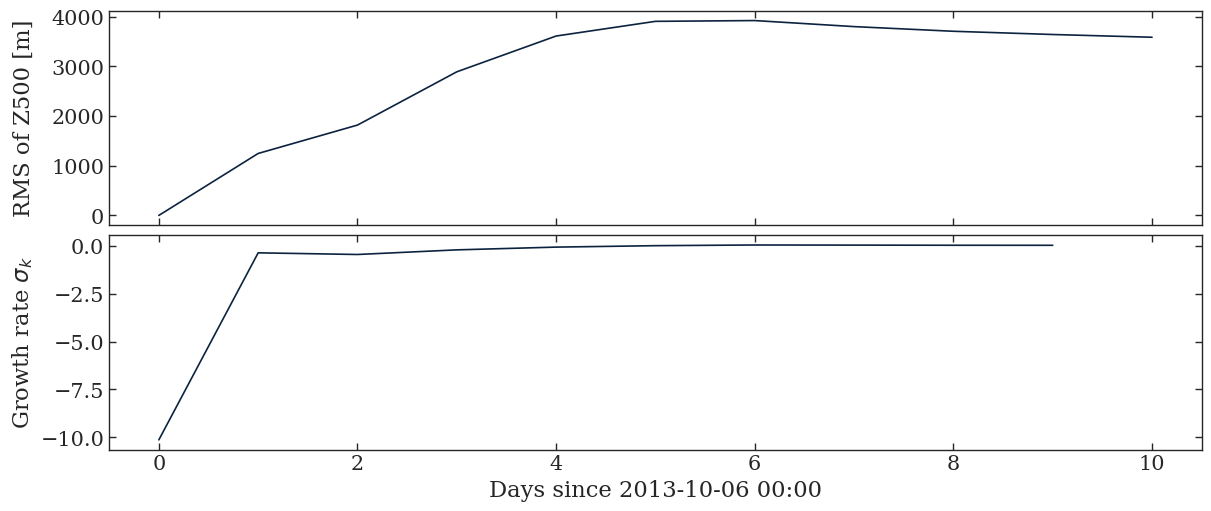

In [16]:
fig, (ax_rms, ax_sigma) = plt.subplots(2, sharex=True, figsize=(12, 5))

ax_rms.plot(ks, rms1.values)
ax_sigma.plot(ks[:-1], sigma_k1)

ax_rms.set_ylabel("RMS of Z500 [m]")

ax_sigma.set_xlabel("Days since 2013-10-06 00:00")
ax_sigma.set_ylabel("Growth rate $\sigma_k$")

format_plot()
save_plot("../plots/lab1", "factor1")

# all factors

In [13]:
rmss = {k: rms(v) for k, v in results.items()}
sigma_ks = {k: sigma_k(v) for k, v in rmss.items()}

In [18]:
for k, sigmas in sigma_ks.items():
    print(k, sigmas)

4 [-9.10595148 -0.32025987 -0.35921633 -0.25366769 -0.14479203 -0.05838039
 -0.01189715  0.01400417  0.03032963  0.05079821]
2 [-9.57012908e+00 -4.42354910e-01 -3.94390273e-01 -2.65828165e-01
 -1.13179695e-01 -2.91284930e-02  5.80014065e-03  3.23998568e-02
  4.42942005e-02  4.25118822e-02]
1 [-1.01245030e+01 -3.77052878e-01 -4.63441899e-01 -2.22472893e-01
 -7.86989923e-02 -4.01238996e-03  3.14952710e-02  2.50266216e-02
  1.76553990e-02  1.53591056e-02]
0.5 [-1.05800779e+01 -2.52809342e-01 -4.81126533e-01 -2.08303887e-01
 -4.75464860e-02  1.64666650e-02  2.06069597e-02  1.41957606e-02
  1.11138951e-02  8.25110117e-03]
0.25 [-1.10554350e+01 -3.08150702e-01 -4.34329880e-01 -1.28677688e-01
 -2.26551534e-02  6.50660361e-03  1.31369872e-02  3.35962613e-03
 -7.58741855e-03  1.78425053e-02]
0.125 [-11.47204045  -0.41970447  -0.25280166  -0.10634195  -0.04382818
  -0.02834195  -0.02271349  -0.01328267  -0.0170179    0.02375018]
0.0625 [-1.18720861e+01 -4.12993965e-01 -2.12811955e-01 -9.56231440

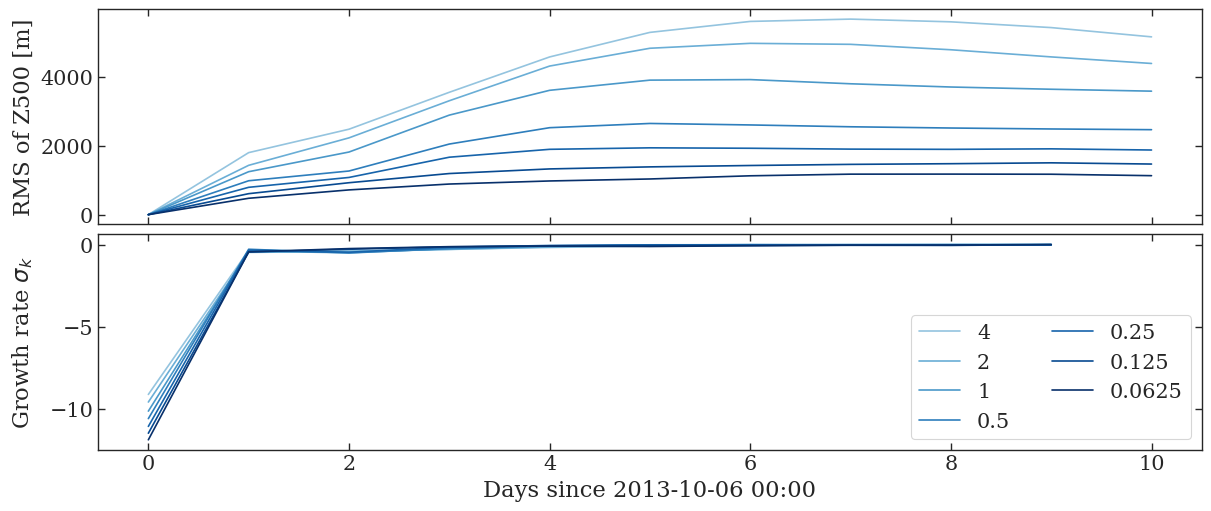

In [14]:
fig, (ax_rms, ax_sigma) = plt.subplots(2, sharex=True, figsize=(12, 5))

cmap = matplotlib.colormaps["Blues"](np.linspace(0.4, 1, len(results)))

for k, color in zip(results.keys(), cmap):
    rms_k = rmss[k]
    sigma_k_k = sigma_ks[k]
    ax_rms.plot(ks, rms_k.values, color=color)
    ax_sigma.plot(ks[:-1], sigma_k_k, color=color, label=k)

ax_rms.set_ylabel("RMS of Z500 [m]")

ax_sigma.set_xlabel("Days since 2013-10-06 00:00")
ax_sigma.set_ylabel("Growth rate $\sigma_k$") 
ax_sigma.legend(ncols=2)

format_plot()
save_plot("../plots/lab1", "all_factors")